In [1]:
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# **Reading the CSV files**

In [2]:
# Read the CSV file
filenames = ['sensex_1990_to_2014.csv',
             'nifty_1994_to_2014.csv',
             'nifty_2000_to_2024.csv']

file_name = 'nifty_1994_to_2014.csv'
#file_name = 'nifty_1994_to_2014.csv'
#file_name = 'nifty_2000_to_2024.csv'

data = pd.read_csv(file_name)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0
1,2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0
2,2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0
3,2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0
4,2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0


In [3]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000,1700.000000
mean,5291.749764,5336.862885,5241.120997,5290.119381,5290.119381,38655.058824
std,996.396802,989.287755,1003.653913,996.116806,996.116806,74383.681317
min,2553.600098,2585.300049,2252.750000,2524.199951,2524.199951,0.000000
25%,4882.237305,4935.449829,4835.637451,4887.637451,4887.637451,0.000000
50%,5342.224854,5382.899902,5297.350098,5334.349854,5334.349854,0.000000
75%,5888.749878,5923.625122,5844.474976,5889.887451,5889.887451,0.000000
max,7942.250000,7968.250000,7939.200195,7954.350098,7954.350098,437000.000000


# **Calculate the Technical Indicator**

In [4]:
# Define the parameters
sma_window_size = 3
ema_smoothing_param = 0.2
williams_r_window_size = 3
RSI_window_size = 14
ATR_window_size = 14
VR_window_size = 14

k_param = 10                 # Defining the k parameter for KNN algorithm
training_set_ratio = 0.9     # Defining the training set for KNN algorithm
enable_knn_normalization = True

In [5]:
def williams_r(highs, lows, closes, window):
    highest_high = highs.rolling(window=window).max()
    lowest_low = lows.rolling(window=window).min()
    r = ((highest_high - closes) / (highest_high - lowest_low)) * -100
    return r

def calculate_rsi(data, window):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_atr(data, window):
    tr1 = data['High'] - data['Low']
    tr2 = abs(data['High'] - data['Close'].shift(1))
    tr3 = abs(data['Low'] - data['Close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

def calculate_vr(data, window):
    tr = data['High'] - data['Low']
    tr_prev = tr.shift(1).rolling(window=window).mean()
    vr = tr / tr_prev
    return vr

def TI_calculations(data):
    data['returns'] = -data['Close'].diff(-1)
    #data['SMA_Close'] = data['Close'].rolling(window=sma_window_size).mean()
    #data['EMA_Close'] = data['Close'].ewm(alpha=ema_smoothing_param).mean()
    #data['Williams %R'] = williams_r(data['High'], data['Low'], data['Close'], window=williams_r_window_size)
    #data['RSI'] = calculate_rsi(data, window=RSI_window_size)
    #data['ATR'] = calculate_atr(data, window=ATR_window_size)
    #data['VR'] = calculate_vr(data, window=VR_window_size)
    
    data.drop(columns=['Date','Open','High','Low'],inplace=True)
    
    # Remove non-numeric values
    data = data.apply(pd.to_numeric, errors='coerce')
    data.dropna(inplace = True)
    return data

data = TI_calculations(data)
data.tail()

,Close,Adj Close,Volume,returns
1694,7891.100098,7891.100098,115200,22.100098
1695,7913.200195,7913.200195,104100,-6.900391
1696,7906.299805,7906.299805,118500,-1.549805
1697,7904.750000,7904.750000,142800,31.299805
1698,7936.049805,7936.049805,120000,18.300293


# **KNN Search with euclidean distance metrics**

In [6]:
train_set_length = int(training_set_ratio*data.shape[0])     # 90% of the data is used for training

**Algorithm**

1) The data is normalized first.Normalization ensure that the distance between two point for attribute 1 is in the same scale as the distance between any other two points.The distances only will be in the range 0 to 1.
2) The euclidean distances of the current day price,TIs(query) are calculated with respect to all the element training set.
3) The whole dataset is then sorted based on this training set in ascending order and then the first 'k' row are returned

In [7]:
def knn_search(data,query,k,enable_normalization = enable_knn_normalization):
    
    # Scaling the data
    if enable_normalization:
        query = (query - data.min())/(data.max() - data.min())
        temp_data = (data - data.min())/(data.max() - data.min())
    else:
        temp_data = data
        
    neighbors_model = NearestNeighbors(n_neighbors=k, metric='euclidean')
    neighbors_model.fit(temp_data)
    query = query.values.reshape(1,-1) 
    distances, indices = neighbors_model.kneighbors(query)
    
    return data.iloc[indices[0]]

sorted_data = knn_search(data,data.iloc[-1,:],10)

In [8]:
sorted_data

,Close,Adj Close,Volume,returns
1698,7936.049805,7936.049805,120000,18.300293
1694,7891.100098,7891.100098,115200,22.100098
1693,7875.299805,7875.299805,117300,15.800293
1696,7906.299805,7906.299805,118500,-1.549805
1691,7874.250000,7874.250000,126700,23.250000
1675,7795.750000,7795.750000,122100,34.850098
1695,7913.200195,7913.200195,104100,-6.900391
1674,7767.850098,7767.850098,120100,27.899902
1662,7751.600098,7751.600098,113100,35.549805
1678,7748.700195,7748.700195,116500,42.699707


In [9]:
estimated_price_dictionary = {}
actual_price_dictionary = {}
for file in filenames:
    data = pd.read_csv(file)
    data = TI_calculations(data)
    
    actual_close_price = []
    estimated_close_price = []
    for i in tqdm(range(data.shape[0]-train_set_length-1),desc = f"Processing {file} : "):
        data_for_search = data.iloc[i:i+train_set_length,:]
        query = data.iloc[i+train_set_length,:]
    
        sorted_data = knn_search(data_for_search,query,k_param)
        estimated_return = sorted_data['returns'].mean()
    
        estimated_close_price.append(query['Close'] + estimated_return)
        actual_close_price.append(data.iloc[i+train_set_length+1,:]['Close'])

    # Error metrics
    estimated_close_price = np.array(estimated_close_price)
    actual_close_price = np.array(actual_close_price)

    estimated_price_dictionary[file] = estimated_close_price
    actual_price_dictionary[file] = actual_close_price

Processing nifty_2000_to_2024.csv : 100%|██| 4438/4438 [00:21<00:00, 207.32it/s]


# **Visualization**

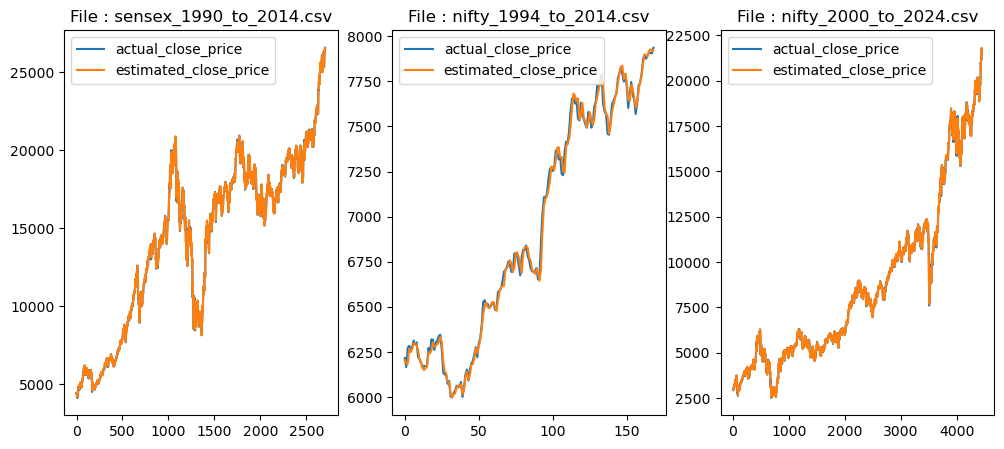

In [10]:
plt.figure(figsize = (12,5))

plt.subplot(131)
plt.title(f"File : {filenames[0]}")
plt.plot(actual_price_dictionary[filenames[0]])
plt.plot(estimated_price_dictionary[filenames[0]])
plt.legend(['actual_close_price','estimated_close_price'])

plt.subplot(132)
plt.title(f"File : {filenames[1]}")
plt.plot(actual_price_dictionary[filenames[1]])
plt.plot(estimated_price_dictionary[filenames[1]])
plt.legend(['actual_close_price','estimated_close_price'])

plt.subplot(133)
plt.title(f"File : {filenames[2]}")
plt.plot(actual_price_dictionary[filenames[2]])
plt.plot(estimated_price_dictionary[filenames[2]])
plt.legend(['actual_close_price','estimated_close_price'])

plt.show()

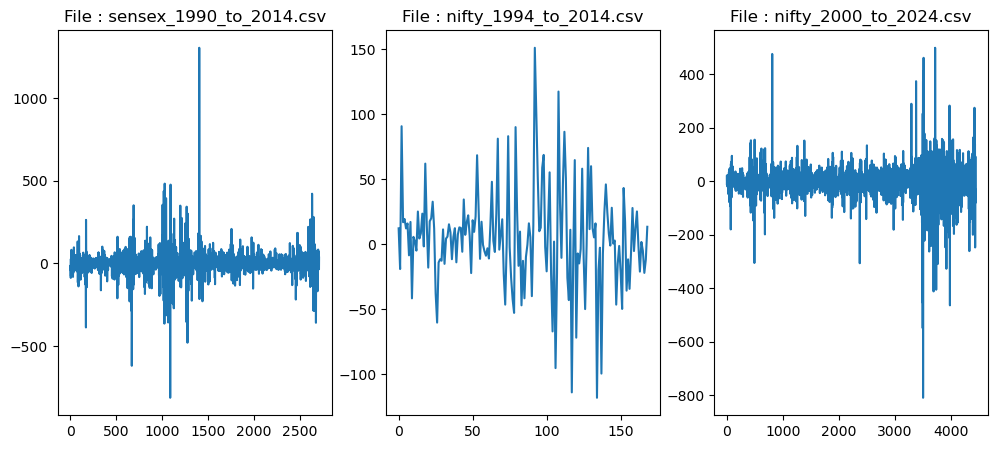

In [11]:
plt.figure(figsize = (12,5))

plt.subplot(131)
plt.title(f"File : {filenames[0]}")
plt.plot(actual_price_dictionary[filenames[0]] - estimated_price_dictionary[filenames[0]])

plt.subplot(132)
plt.title(f"File : {filenames[1]}")
plt.plot(actual_price_dictionary[filenames[1]] - estimated_price_dictionary[filenames[1]])

plt.subplot(133)
plt.title(f"File : {filenames[2]}")
plt.plot(actual_price_dictionary[filenames[2]] - estimated_price_dictionary[filenames[2]])

plt.show()

In [12]:
for file in filenames:
    error = actual_price_dictionary[file] - estimated_price_dictionary[file]
    print(f"The rmse for {file} with enable_knn_normalization as {enable_knn_normalization} is {np.sqrt(np.mean(error**2))} <br>")

The rmse for sensex_1990_to_2014.csv with enable_knn_normalization as True is 69.56409629760876 <br>
The rmse for nifty_1994_to_2014.csv with enable_knn_normalization as True is 38.41585383388505 <br>
The rmse for nifty_2000_to_2024.csv with enable_knn_normalization as True is 50.3351461228365 <br>


# **Result**

The rmse for sensex_1990_to_2014.csv with enable_knn_normalization as True is 155.16112961199286 <br>
The rmse for nifty_1994_to_2014.csv with enable_knn_normalization as True is 52.510672096852375 <br>
The rmse for nifty_2000_to_2024.csv with enable_knn_normalization as True is 80.39006232530932 <br>

The rmse for sensex_1990_to_2014.csv with enable_knn_normalization as False is 216.03921169398518 <br>
The rmse for nifty_1994_to_2014.csv with enable_knn_normalization as False is 58.886214070856674 <br>
The rmse for nifty_2000_to_2024.csv with enable_knn_normalization as False is 71.89880566902163 <br>

**Only Close price**

The rmse for sensex_1990_to_2014.csv with enable_knn_normalization as True is 69.56409629760876 <br>
The rmse for nifty_1994_to_2014.csv with enable_knn_normalization as True is 38.41585383388505 <br>
The rmse for nifty_2000_to_2024.csv with enable_knn_normalization as True is 50.3351461228365 <br>